# Lab 3 : Document Clustering

In this lab, we will work with abstracts of research papers published on different aspects of coronaviruses over the years. Our goal is to segement the abstracts into different clusters based on the similarities in the topics that the abstracts talk about.

1. We will begin by first using TF-IDF vectorizer to create a feature space to represent the abstracts.
2. We will then use kmeans and hierarchical clustering to creates 3 different clusters and visualize them.
3. We will also look at parameters like intra-cluster and inter-cluster distances to access the efficacy of the clustering that we have done.
4. At last, we will look at the most important words for each of the clusters that we have created.

## Important Instructions - 

### 1. This lab also contains subjective questions. Please write your answers in the same markdown cell in which the question is asked.
2. Please make changes only inside the graded function. Do not make changes anywhere else in the notebook.
3. Please read the description of every graded function very carefully. Description clearly states what is the expectation of each graded function. 
4. After almost every graded function, there is a cell which you can run and see if the expected output matches the output you are getting. 
5. The expected output provided is just a way for you to access the correctness of your code. The code will be tested on other cases also.

## Submission Instructions -

#### 1. You need to submit the completed jupyter notebook along with a pdf version of the notebook.

#### 2. Please name your submissions according to the instructions provided earlier


## Grading Policy -
1. You will receive full credit if the code passes all test cases.
2. In case of error, partial credit will be awarded based on your code and no. of test cases passed .

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import json
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from  sklearn.cluster import AgglomerativeClustering,SpectralClustering,KMeans
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
#setting stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [3]:
#the purpose of clean_abstract function is to remove stopwords, punctuation, 
#special characters as well as extra spaces
def clean_abstract(abstract):
    '''Clean the text, with the option to remove stopwords'''
    
    # Convert words to lower case and split them
    abstract = abstract.lower()
    # Clean the text
    abstract = re.sub(r"<br />", " ", abstract)
    abstract = re.sub(r"[^a-z]", " ", abstract)
    abstract = re.sub(r"   ", " ", abstract) # Remove any extra spaces
    abstract = re.sub(r"  ", " ", abstract)
    #remove stopwords
    stops = set(stopwords.words("english"))
    tokenized = word_tokenize(abstract)
    abstract = [w for w in tokenized if not w in stop_words and len(w) > 3]
    abstract = " ".join(abstract)


    
    # Return a list of words
    return abstract

In [4]:
#extracting abstracts and corresponding paper ids from json data
abstracts=[]
paper_ids=[]
count=0
for file in os.listdir("noncomm_use_subset") :
    with open('noncomm_use_subset/' + file) as json_data:
        data=json.load(json_data)
        l=data['abstract']
        if len(l) >= 1 :
            count+=1
            abstract=""
            paper_ids.append(data['paper_id'])
            for d in l :
                abstract+=d["text"]+" "
            abstract=clean_abstract(abstract)
            abstracts.append(abstract)

In [5]:
#creating dataframe
data=pd.DataFrame()
data['paper_id']=paper_ids
data['abstract']=abstracts

In [6]:
#converting the data frame abstract cols into rows
list_abs=data['abstract'].values.tolist()

## Graded Function 1 : create_document_matrix (3 marks)

Pupose : To create a document matrix using sklearn's TfidfVectorizer. We will create features using tf-idf values of words. Every row of the matrix represents one document in the created feature space. We will use the top 1000 words and set maximum document frequency to 0.4

You should return the trained vectorizer object and the document matrix.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
def create_document_matrix(max_features,max_df) :
    '''
    Input - max_features to keep and maximum document frequency
    Output - trained vectorizer object and matrix
    '''
    ##start code here
    vectorizer = TfidfVectorizer(max_features=max_features,max_df=max_df)
    X = vectorizer.fit_transform(list_abs)
    ##end code here
    
    return vectorizer, X

In [8]:
vectorizer,doc_matrix=create_document_matrix(1000,0.4)
print(doc_matrix.shape)

(1704, 1000)


## Expected Output -

doc_matrix.shape = (1704,1000)

## Graded Function 2 : create_feature_dataFrame (2 marks)

Pupose : To convert the document matrix created above into a datframe with feature words as column names

You should return a dataframe.

In [9]:
import scipy.sparse
def create_feature_dataFrame(doc_matrix,vectorizer) :
    '''
    Input - document matrix and vectorizer created above
    Output - feature dataframe
    '''
    ##start code here
    names=vectorizer.get_feature_names()
    doc_frame=pd.DataFrame(doc_matrix.todense(),columns=names)
    ##end code here
    return doc_frame

In [10]:
feature_data=create_feature_dataFrame(doc_matrix,vectorizer)
print(feature_data.columns[:10])

Index(['abbreviations', 'ability', 'able', 'absence', 'access', 'according',
       'accurate', 'acid', 'acids', 'acquired'],
      dtype='object')


## Expected Output -

feature_data.columns[:10] = Index(['abbreviations', 'ability', 'able', 'absence', 'access', 'according',
       'accurate', 'acid', 'acids', 'acquired'],
      dtype='object')

In [11]:
#we will maintain another dataframe all_data which will contain all the feature data and also cluster information and
#principal components
all_data = pd.DataFrame()
for c in feature_data.columns :
    all_data[c]=feature_data[c]

## Graded Function 3 : do_pca (2 marks)

Purpose - To get the first 2 principal components of feature data using Scikit learn's PCA utility and add both of these to the all_data dataframe

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def do_pca(n_components) :
    '''
    Input - the no. of components after doing pca
    '''
    global all_data
    pca = PCA(n_components=n_components)  
    principalComponents =pca.fit_transform(feature_data)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    all_data = all_data.join(principalDf)

In [13]:
do_pca(2)
print(all_data.shape)


(1704, 1002)


## Expected Output -

all_data.shape = (1704,1002)

## Graded Function 4 : visualize_clusters (3 marks)

Purpose - To create a scatter plot with 2nd principal compenent on y-axis and 1st principal component on x-axis.

Points belonging to different clusters should be represented with different colours. 

You should label the axis of the plot and also a legend for color to cluster no. mapping.

In [14]:
def visualize_clusters(cluster_column) :
    '''
    Input - column in all_data dataframe which contains cluster no. for the observations
    '''
     ##start code here
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1, 2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = all_data[cluster_column] == target
        ax.scatter(all_data.loc[indicesToKeep, 'principal component 1']
                   , all_data.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()   

## Graded Function 5 : do_agglomerative (10 marks)

Purpose - To do agglomerative clustring of the feature data using sklearn's AgglomerativeClustering . You should tune distance_threshold parameter such that the no. of clusters that you get is 3. Please keep the compute_full_tree parameter to true. 

In [15]:
from sklearn.cluster import AgglomerativeClustering
def do_agglomerative(distance_threshold) :
    '''
    Input - distance_threshold to be used for clustering
    Output - clusting object after fitting on the data
    '''
     ##start code here
    
    clust = AgglomerativeClustering(compute_full_tree=True,distance_threshold=distance_threshold,n_clusters=None).fit(feature_data)   
    print(clust.n_clusters_)
    ##end code here
    return clust

In [16]:
#we will add the clustering labels to the all_data dataframe with column name 'cluster1'
clustering1=do_agglomerative(5.5)

3


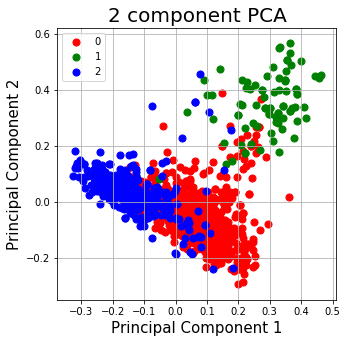

In [17]:
#we will now use visualize the agglomerative clustering results
all_data['cluster1']=list(clustering1.labels_)
visualize_clusters("cluster1")

## Graded Function 6 : do_kmeans (5 marks)

Purpose - To do kmeans clustring of the feature data using sklearn's KMeans . You should set no. of clusters to 3. 

In [18]:
from sklearn.cluster import KMeans
def do_kmeans(n_clusters) :
    '''
    Input - no. of clusters
    Output - clusting object after fitting on the data
    '''
     ##start code here
    kmeans = KMeans(n_clusters=3, random_state=0).fit(feature_data)  
    
    ##end code here
    return kmeans

In [19]:
# #we will add the clustering labels to the all_data dataframe with column name 'cluster2'
clustering2=do_kmeans(3)
all_data['cluster2']=list(clustering2.labels_)

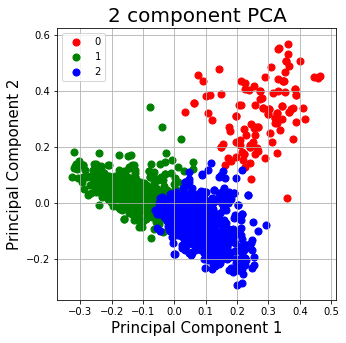

In [20]:
visualize_clusters("cluster2")

## Note -

You can experiment and see that 4 clusters will result in a bit more mix between the clusters(this is evident in visulization of kmeans results) which is not desirable since the main aim of unsupervised clustering is to get well-separated closely packed clusters. Hence, we have used 3 clusters in the entire analysis

## Graded Function 7 : get_cluster_centers (10 marks)

Purpose - To get the 3 cluster centers in agglomerative clustering. 

A cluster center is defined as the average of all points belonging to that cluster.

You should return a numpy array with 3 rows and 1000 columns

In [21]:
def get_cluster_centers() :
    '''
    Output - the 3 cluster centers. 
    '''
    ##start code here
    centers1=np.zeros((3,all_data.shape[1]))
    centers1[0,:]=(all_data[all_data['cluster1'] == 0]).mean(axis=0)
    centers1[1,:]=(all_data[all_data['cluster1'] == 1]).mean(axis=0)
    centers1[2,:]=(all_data[all_data['cluster1'] == 2]).mean(axis=0)
    drop=all_data.shape[1]-feature_data.shape[1]     
    centers1=centers1[:, :-drop]  

    return centers1

In [22]:
centers1=get_cluster_centers()
print(centers1.shape)
print(centers1[0,:5])
print(centers1[1,:5])
print(centers1[2,:5])

(3, 1000)
[0.00206657 0.00345347 0.00333645 0.00338688 0.00503021]
[0.         0.00103512 0.         0.00227696 0.00444854]
[0.00748894 0.01055415 0.00408909 0.00369441 0.0029677 ]


## Expected Output -

centers1.shape = (3, 1000)

centers1[0,:5] = [0.00201787 0.00411695 0.00325781 0.00330705 0.00509594]

centers1[1,:5] = [0.         0.00103512 0.         0.00227696 0.00444854]

centers1[2,:5] = [0.00797321 0.00919296 0.00435351 0.00393331 0.00265398]

Note - Your output can vary slightly

## Graded Function 8 : get_distances (10 marks)

Purpose - To get the intra-cluster and inter-cluster distances. We will use l2 norm as the distance metric between 2 
points in the feature space. 

intra-cluster distance - sum of distances of each point from its corresponding cluster

inter-cluster distance - sum of distances between every two cluster centers

In [23]:
from numpy import linalg as LA
from scipy.spatial import distance
def get_distances(centers,cluster_column):
    '''
    Input - cluster centers, column in all_data dataframe which contains cluster no. for the observations
    Output - Inter and Intra cluster distances
    '''
    ##start code here
    inter=0.0
    intra=0.0
    

    d1= distance.euclidean(centers[0,:], centers[1,:])
    d2= distance.euclidean(centers[0,:], centers[2,:])
    d3= distance.euclidean(centers[1,:], centers[2,:])
    dd=distance.cdist(centers, centers, 'euclidean')
    inter=(np.ndarray.sum(dd)/2)  
    clst_0=((all_data[all_data[cluster_column] == 0]).drop(['principal component 1', 'principal component 2', 'cluster1','cluster2'], axis=1)).to_numpy()
    clst_1=((all_data[all_data[cluster_column] == 1]).drop(['principal component 1', 'principal component 2', 'cluster1','cluster2'], axis=1)).to_numpy()
    clst_2=((all_data[all_data[cluster_column] == 2]).drop(['principal component 1', 'principal component 2', 'cluster1','cluster2'], axis=1)).to_numpy()
    cc_0 = centers[0,:].reshape(1, -1)
    cc_1 = centers[1,:].reshape(1, -1)
    cc_2 = centers[2,:].reshape(1, -1)
    dd_1=distance.cdist(clst_0, cc_0, 'euclidean') 
    dd_2=distance.cdist(clst_1, cc_1, 'euclidean') 
    dd_3=distance.cdist(clst_2, cc_2, 'euclidean') 
    intra=((np.ndarray.sum(dd_1)+np.ndarray.sum(dd_2)+np.ndarray.sum(dd_3)))
    print(inter,intra)
    ##end code here
    
    

In [24]:
get_distances(centers1,"cluster1")

1.2671668099641384 1638.4819357551503


## Expected Output - 

get_distances(centers1,"cluster1") = (1.2759084030891206, 1638.4871525318163)

Note - the output may not match exactly.

In [25]:
from scipy.spatial import distance

centers2=clustering2.cluster_centers_
get_distances(centers2,"cluster2")

1.199359805023716 1634.2370022902248


## Expected Output - 

get_distances(centers2,"cluster2") = (1.2025709556400597, 1634.2309524387529)

Note - the output may not match exactly.

## Question 1 : (5 marks)

(a) Which clustering algorithm resulted in lower intra cluster distances? Give one possible explanation for the result.

Answer - Lower intra cluster distances were observed in K-means clustering. Its clearly visible from the plots above that in k-means clustering the points are really well clustered together in a cluster whereas in the agglomerative clustering points are scattered. I think since agglomerative clustering is a type of hierarchical clustering where the number of clusters is not specified the clusters are spread and the intra cluster distance is higher.

(b) Which clustering algorithm resulted in higher inter cluster distances? Give one possible explanation for the result.

Answer - Higher inter cluster distances were observed in the agglomerative clustering algorithm.  Taking further the explanation in (a), since the clusters obatined from agglomerative clustering algorithm are larger and more spread apart their centroids are far apart (relative to k-means) and this causes higher inter cluster distances.

## Graded Function 9 : imp_words (10 marks)

Purpose - To get the list of all word features sorted in ascending order for a particular cluster. 
For every word, sum its feature value across all observations for the particular cluster. You will then sort the words based on these values.

The output list will have tuples with word as the first element of the tuple and sum of values as the 2nd element.

Please note that the cluster no. 'k' in the function below is in the range (0,n_clusters-1)

Note - On multiple runs of kmeans, the cluster nos. can change. So, I have provided 3 different lists of words you can possible get. The lists are in no particular order of cluster no.

In [26]:
def imp_words(k,cluster_column) :
    '''
    Input - cluster no., column in all_data dataframe which contains cluster no. for the observations
    Output - list of words
    '''
     ##start code here
    summ=((all_data[all_data[cluster_column] == k]).sum(axis=0))
    summ=summ.drop(['principal component 1', 'principal component 2', 'cluster1','cluster2'])
    zip_summ=list(zip(summ.keys(),summ.tolist()))
    zip_summ.sort(key=lambda tup: tup[1]) 
    ##end code here
    return zip_summ

In [27]:
print(imp_words(0,"cluster2")[-30:])

[('infections', 2.2711904723026755), ('rate', 2.3851497566941213), ('spread', 2.4339596620077577), ('outbreaks', 2.4448466217168443), ('clinical', 2.480716722411819), ('high', 2.4862551087724833), ('control', 2.6185904999649545), ('viral', 2.6545290254337788), ('south', 2.671984464366165), ('disease', 3.003257776009313), ('severe', 3.0054640934103154), ('public', 3.0969754432777106), ('patients', 3.620010746239265), ('arabia', 4.180992360972853), ('human', 4.568881897228453), ('virus', 4.749963660758422), ('cases', 4.857058731693339), ('saudi', 5.1061649166292336), ('health', 5.240101413501149), ('korea', 5.872915103560175), ('transmission', 6.585784816818934), ('camels', 6.6181653145935435), ('infection', 7.28320757668681), ('coronavirus', 8.04405694398697), ('outbreak', 8.299096118471311), ('syndrome', 9.595293185932494), ('respiratory', 10.560437592994186), ('middle', 11.811602742149473), ('east', 11.815963303669848), ('mers', 43.21872232233398)]


In [28]:
print(imp_words(1,"cluster2")[-30:])

[('specific', 13.366478605161715), ('analysis', 13.39510611312861), ('sars', 13.742952833717194), ('sequence', 13.91886492714108), ('cellular', 14.050768543909232), ('domain', 14.088263465743696), ('induced', 14.226434454501318), ('type', 14.708782577986836), ('using', 14.891413463235224), ('binding', 14.989590529932464), ('also', 15.251556812458757), ('activity', 15.319640155901345), ('mice', 15.733809309444467), ('genes', 16.173659598878345), ('golgi', 16.279227482697824), ('replication', 16.467203035096812), ('immune', 17.66099356312791), ('viruses', 17.764832914308375), ('human', 18.803513074810173), ('host', 18.807643801031727), ('infection', 18.956544945085632), ('membrane', 19.40092623499879), ('gene', 20.63447017213101), ('viral', 26.203574248517402), ('proteins', 27.737379546823373), ('expression', 29.103495334793916), ('virus', 33.784347285036304), ('cell', 36.97548094123772), ('protein', 38.761688320150874), ('cells', 48.308763985215506)]


In [29]:
print(imp_words(2,"cluster2")[-30:])

[('among', 15.924762488104765), ('associated', 15.942333619257777), ('years', 16.205997231019115), ('pathogens', 16.34735386654629), ('public', 17.301866184824725), ('group', 17.333107190351612), ('data', 17.357868026894526), ('china', 17.51516714321074), ('acute', 17.718227233557467), ('samples', 17.793894655052302), ('results', 18.055350709707486), ('infectious', 18.197000730907046), ('cases', 18.254113816885873), ('risk', 19.21517196362511), ('diseases', 19.510753807346983), ('viral', 19.616549537640875), ('infections', 19.788340443024516), ('pneumonia', 19.807299617618884), ('treatment', 19.82702905568107), ('influenza', 20.01613621826952), ('viruses', 20.16570255091967), ('children', 20.7379479216139), ('study', 25.009765704522884), ('infection', 25.343772814330922), ('clinical', 26.257861580257927), ('disease', 28.555217886248574), ('virus', 28.6251010066726), ('respiratory', 35.1388537347508), ('health', 35.69303263803952), ('patients', 43.09023054071637)]


## 1 :

[('receptor', 12.55695761824851),
 ('antibody', 12.645329920745596),
 ('specific', 12.663586706878325),
 ('antiviral', 13.205611551436832),
 ('sars', 13.375509135150393),
 ('type', 13.701909300952396),
 ('cellular', 13.830636476160848),
 ('also', 13.877612565312328),
 ('induced', 14.069580345432174),
 ('domain', 14.088263465743692),
 ('binding', 14.581027802249706),
 ('genes', 14.625301884739228),
 ('activity', 15.292686196946374),
 ('viruses', 15.447736257797823),
 ('mice', 15.612430521144065),
 ('replication', 15.927922134181905),
 ('golgi', 16.279227482697824),
 ('immune', 16.61610089653616),
 ('gene', 17.709492859711876),
 ('host', 17.782863417900696),
 ('human', 17.901200271000473),
 ('infection', 18.490241498291383),
 ('membrane', 19.197083670411057),
 ('viral', 23.392795808148215),
 ('proteins', 26.719984486805544),
 ('expression', 29.09694080063638),
 ('virus', 30.309654023304617),
 ('cell', 36.53661900503533),
 ('protein', 38.17931000604836),
 ('cells', 48.206916674500626)]
 
## 2 :
[('infections', 2.271190472302675),
 ('rate', 2.385149756694121),
 ('spread', 2.433959662007758),
 ('outbreaks', 2.4448466217168443),
 ('clinical', 2.4807167224118194),
 ('high', 2.4862551087724847),
 ('control', 2.618590499964954),
 ('viral', 2.654529025433779),
 ('south', 2.6719844643661648),
 ('disease', 3.003257776009313),
 ('severe', 3.005464093410315),
 ('public', 3.09697544327771),
 ('patients', 3.6200107462392657),
 ('arabia', 4.180992360972854),
 ('human', 4.568881897228452),
 ('virus', 4.749963660758424),
 ('cases', 4.85705873169334),
 ('saudi', 5.106164916629234),
 ('health', 5.240101413501151),
 ('korea', 5.872915103560177),
 ('transmission', 6.585784816818933),
 ('camels', 6.6181653145935435),
 ('infection', 7.283207576686812),
 ('coronavirus', 8.044056943986968),
 ('outbreak', 8.29909611847131),
 ('syndrome', 9.595293185932503),
 ('respiratory', 10.560437592994184),
 ('middle', 11.811602742149475),
 ('east', 11.815963303669847),
 ('mers', 43.218722322333996)]
 
## 3 :

[('among', 16.61456562650734),
 ('associated', 16.91042745299649),
 ('public', 17.48704955739214),
 ('china', 17.51516714321074),
 ('pathogens', 17.53392964956187),
 ('using', 17.81796237102735),
 ('group', 17.8673258093374),
 ('acute', 18.184657525956776),
 ('cases', 18.563827780021402),
 ('data', 18.667313163847524),
 ('results', 18.731343206463645),
 ('risk', 19.259625969610042),
 ('infectious', 19.656115669193778),
 ('samples', 19.66342648579428),
 ('pneumonia', 19.855858093341244),
 ('treatment', 20.01960420846876),
 ('infections', 20.15614780959232),
 ('diseases', 20.72206493032006),
 ('children', 20.73794792161389),
 ('influenza', 21.11148110201874),
 ('viral', 22.427327978010066),
 ('viruses', 22.482799207430205),
 ('infection', 25.810076261125168),
 ('study', 26.123502883634227),
 ('clinical', 26.863254544931188),
 ('disease', 29.676257347523574),
 ('virus', 32.09979426840429),
 ('respiratory', 35.57112978970868),
 ('health', 35.99831467549281),
 ('patients', 43.21384755916491)]